In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
import os
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor, HistGradientBoostingRegressor


import mlflow
import mlflow.sklearn

In [9]:
os.environ['USER'] = 'Ruslan'
mlflow.set_tracking_uri("http://localhost:5005")


In [10]:
df = pd.read_excel(r'C:\Users\User\Desktop\oil\data.xlsx')

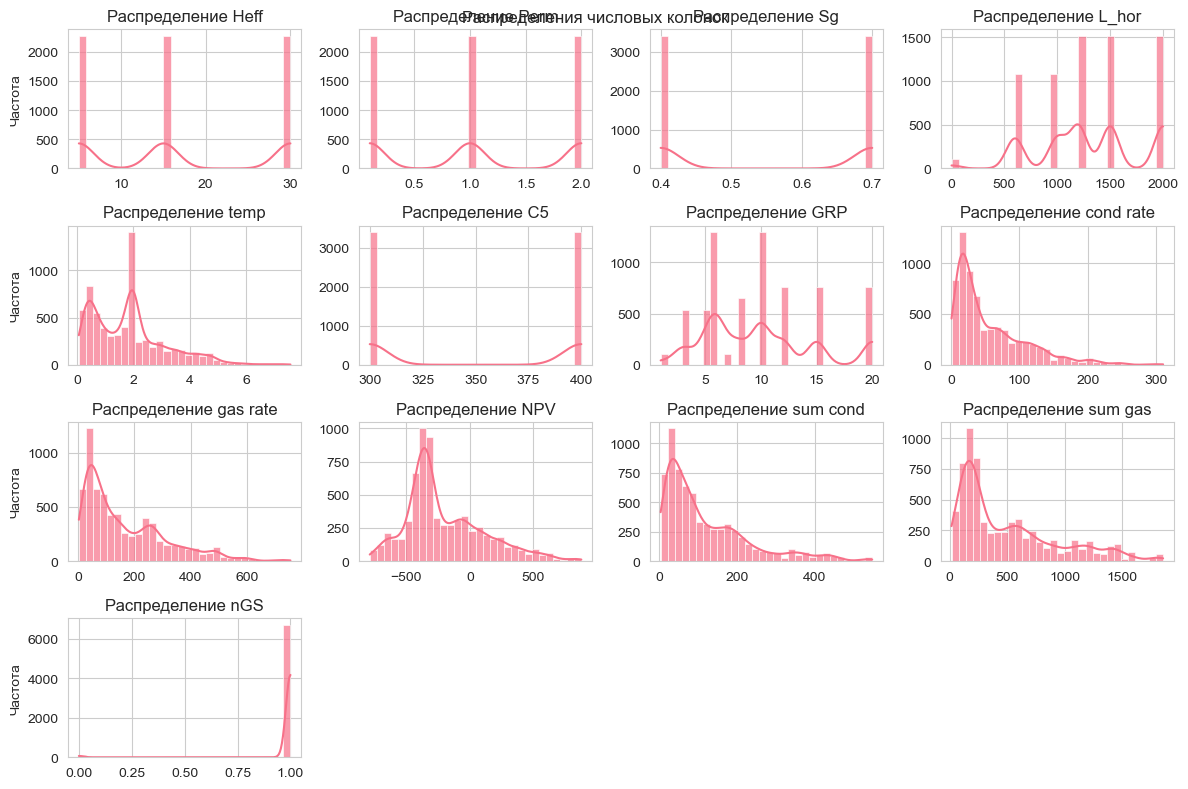

In [11]:
sns.set_style("whitegrid")
sns.set_palette("husl")  # Красивая палитра цветов

# Фильтруем только числовые колонки
numeric_cols = df.select_dtypes(include=[float, int]).columns

# Определяем размер сетки (например, ceil(sqrt(n)) для квадратной формы)
n_cols = len(numeric_cols)
n_rows = int(n_cols ** 0.5) + 1
n_cols_grid = int(n_cols / n_rows) + 1

fig, axes = plt.subplots(n_rows, n_cols_grid, figsize=(12, 8), sharex=False, sharey=False)
axes = axes.flatten()  # Превращаем в 1D-массив для простоты

# Строим графики
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], alpha=0.7)  # Гистограмма с KDE
    axes[i].set_title(f'Распределение {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Частота' if i % n_cols_grid == 0 else '')  # Подпись только слева

# Убираем пустые субплоты, если колонок меньше ячеек
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Автоматическая корректировка расстояний
plt.suptitle('Распределения числовых колонок', fontsize=12, y=0.98)  # Общий заголовок
plt.show()


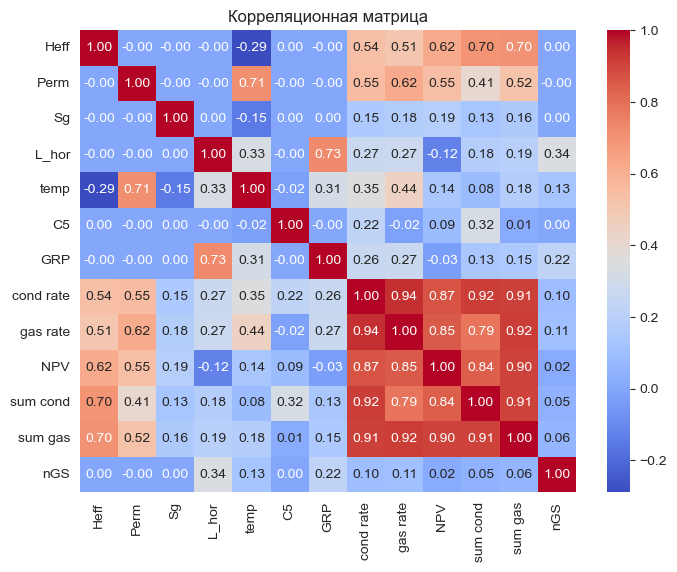

In [12]:
corr=df.select_dtypes(include=['float','int']).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

In [13]:
df.select_dtypes(include=['object']).value_counts()

GS    
GS        3348
NGS       1080
VGS       1080
S-TYPE     648
U-TYPE     648
Name: count, dtype: int64

In [14]:
x=df.drop(['cond rate','gas rate','sum cond','sum gas','NPV'],axis=1)
y=df['NPV']

In [15]:
# One-Hot Encoding для GS
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' избегает мультиколлинеарности
encoded_cols = encoder.fit_transform(x[['GS']])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['GS']))
X = pd.concat([x.drop('GS', axis=1), encoded_df], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
mlflow.set_experiment("Models_NPV")

<Experiment: artifact_location='file:///C:/Users/User/Desktop/oil/mlflow/data_local/270350811286877226', creation_time=1758616366666, experiment_id='270350811286877226', last_update_time=1758616366666, lifecycle_stage='active', name='Models_NPV', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [27]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

def test_model(model, param_grid, model_name, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    with mlflow.start_run(run_name=model_name):
        grid_search.fit(X_train, y_train)
        
        mlflow.log_params(grid_search.best_params_)
        print(f"Лучшие параметры для {model_name}:", grid_search.best_params_)
        print(f"Лучшее R2 на кросс-валидации: {grid_search.best_score_:.4f}")
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2_val = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('R2', r2_val)  # исправлено с r2 на r2_val
        mlflow.log_metric('MAPE', mape)
        mlflow.sklearn.log_model(best_model, "best_model")
        
        print(f"Тестовые метрики для {model_name}:")
        print(f"  MAE = {mae:.2f}")
        print(f"  R2  = {r2_val:.4f}")
        print(f"  MAPE = {mape:.2%}")
        print("-" * 50)
        
        return best_model, mape


In [28]:
#модели для теста
models_to_test = [
    # Ансамблевые методы (градиентный бустинг)
    (XGBRegressor(random_state=42, objective='reg:squarederror'), 
     {'n_estimators': [100, 500], 'learning_rate': [0.01, 0.1], 
      'max_depth': [4, 6], 'subsample': [0.8, 0.9]}, "XGBoost"),
    
    (LGBMRegressor(random_state=42, verbose=-1), 
     {'n_estimators': [100, 500], 'learning_rate': [0.01, 0.1], 
      'max_depth': [4, 6], 'subsample': [0.8, 0.9]}, "LightGBM"),
    
    (CatBoostRegressor(random_state=42, verbose=False),
     {'iterations': [100, 500], 'learning_rate': [0.01, 0.1], 
      'depth': [4, 6], 'l2_leaf_reg': [1, 3]}, "CatBoost"),
    
    (GradientBoostingRegressor(random_state=42),
     {'n_estimators': [100, 500], 'learning_rate': [0.01, 0.1], 
      'max_depth': [3, 4], 'subsample': [0.8, 0.9]}, "GradientBoosting"),
    
    (HistGradientBoostingRegressor(random_state=42),
     {'max_iter': [100, 500], 'learning_rate': [0.01, 0.1], 
      'max_depth': [4, 6], 'l2_regularization': [0, 1]}, "HistGradientBoosting"),
    
    # Ансамблевые методы (бэггинг)
    (RandomForestRegressor(random_state=42),
     {'n_estimators': [100, 500], 'max_depth': [4, 6, None], 
      'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, "RandomForest"),
    
    (ExtraTreesRegressor(random_state=42),
     {'n_estimators': [100, 500], 'max_depth': [4, 6, None], 
      'min_samples_split': [2, 5]}, "ExtraTrees"),
    
    # Другие ансамблевые методы
    (AdaBoostRegressor(random_state=42),
     {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1.0]}, "AdaBoost"),
    
    # Линейные модели
    (Ridge(random_state=42),
     {'alpha': [0.1, 1.0, 10.0, 100.0], 'solver': ['auto', 'svd']}, "Ridge"),
    
    (Lasso(random_state=42),
     {'alpha': [0.1, 1.0, 10.0], 'max_iter': [1000, 5000]}, "Lasso"),
    
    (ElasticNet(random_state=42),
     {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]}, "ElasticNet"),
    
    (BayesianRidge(),
     {'alpha_1': [1e-6, 1e-5], 'alpha_2': [1e-6, 1e-5], 
      'lambda_1': [1e-6, 1e-5], 'lambda_2': [1e-6, 1e-5]}, "BayesianRidge"),
    
    # Методы на основе соседей
    (KNeighborsRegressor(),
     {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 
      'metric': ['euclidean', 'manhattan']}, "KNeighbors"),
    
    # SVM
    (SVR(),
     {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf'], 
      'gamma': ['scale', 'auto'], 'epsilon': [0.1, 0.2]}, "SVR"),
    
    # Нейронные сети
    (MLPRegressor(random_state=42, max_iter=1000),
     {'hidden_layer_sizes': [(100,), (50, 50), (100, 50)], 
      'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001],
      'learning_rate_init': [0.001, 0.01]}, "MLP"),
    
    # Деревья решений
    (DecisionTreeRegressor(random_state=42),
     {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4]}, "DecisionTree")
]

In [35]:
#модели для теста
models_to_test = [
    # SVM
    #(SVR(),
     #{'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf'], 
      #'gamma': ['scale', 'auto'], 'epsilon': [0.1, 0.2]}, "SVR"),
    
    # Нейронные сети
    (MLPRegressor(random_state=42, max_iter=1000),
     {'hidden_layer_sizes': [(100,), (50, 50), (100, 50)], 
      'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001],
      'learning_rate_init': [0.001, 0.01]}, "MLP"),
    
    # Деревья решений
    (DecisionTreeRegressor(random_state=42),
     {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4]}, "DecisionTree")
]

In [34]:
#цикл обучений
#best_models = {}
for model, params, name in models_to_test:
    best_model, mape = test_model(model, params, name, X_train, y_train, X_test, y_test)
    best_models[name] = (best_model, mape)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/09/23 13:02:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Лучшие параметры для MLP: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}
Лучшее R2 на кросс-валидации: 0.9452


2025/09/23 13:02:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Тестовые метрики для MLP:
  MAE = 78.29
  R2  = 0.8794
  MAPE = 77.71%
--------------------------------------------------
🏃 View run MLP at: http://localhost:5005/#/experiments/270350811286877226/runs/c6e75356fda84a2d80e24c53e8a560dc
🧪 View experiment at: http://localhost:5005/#/experiments/270350811286877226
Fitting 5 folds for each of 36 candidates, totalling 180 fits


2025/09/23 13:02:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Лучшие параметры для DecisionTree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучшее R2 на кросс-валидации: 0.9987


2025/09/23 13:02:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Тестовые метрики для DecisionTree:
  MAE = 2.09
  R2  = 0.9995
  MAPE = 2.70%
--------------------------------------------------
🏃 View run DecisionTree at: http://localhost:5005/#/experiments/270350811286877226/runs/3bd0d23d49154aacbec2af7d529e3a28
🧪 View experiment at: http://localhost:5005/#/experiments/270350811286877226


Тестовые метрики для XGBoost:
  MAE = 2.39
  R2  = 1.00
  MAPE= 2.43%


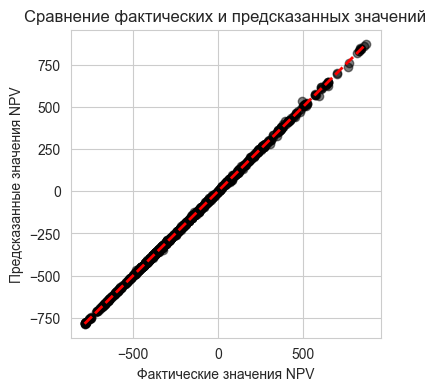

In [43]:
# Оцениваем модель на тестовой выборке
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Тестовые метрики для XGBoost:")
print(f"  MAE = {mae:.2f}")
print(f"  R2  = {r2:.2f}")
print(f"  MAPE= {mape:.2%}")

# Построение графиков для анализа модели

# 1. Scatter plot: Фактические vs. Предсказанные
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения NPV')
plt.ylabel('Предсказанные значения NPV')
plt.title('Сравнение фактических и предсказанных значений')
plt.grid(True)
plt.show()


Топ-10 важных признаков:
      Признак  Важность
1        Perm  0.531540
0        Heff  0.267745
2          Sg  0.091130
3       L_hor  0.063031
5          C5  0.016295
4        temp  0.015308
6         GRP  0.012939
11     GS_VGS  0.000686
8      GS_NGS  0.000684
10  GS_U-TYPE  0.000549


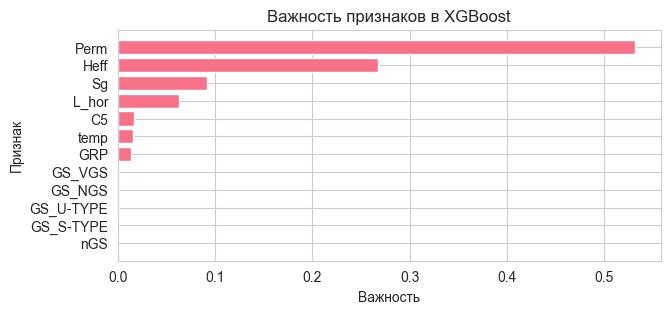

In [45]:
# Определение важности признаков
feature_importances = best_model.feature_importances_
feature_names = X_train.columns  # Названия признаков

# Создаем DataFrame для удобного отображения
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
}).sort_values(by='Важность', ascending=False)

# Выводим топ-10 важных признаков в консоль
print("\nТоп-10 важных признаков:")
print(importance_df.head(10))

# Построение графика важности признаков
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))
plt.barh(importance_df['Признак'][:20], importance_df['Важность'][:20])  # Топ-20 для читаемости
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.title('Важность признаков в XGBoost')
plt.gca().invert_yaxis()  # Инвертируем ось Y для лучшего вида
plt.show()